In [355]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [356]:
df = pd.read_csv('./data/car.data', header=None)

In [357]:
df.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [358]:
df.columns = ['buying','maint','doors','persons','lug_boot','safety','label']

In [359]:
X = df.iloc[:,:-1]

In [360]:
y = df.iloc[:,-1]

In [361]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from time import time

In [362]:
X_transform = pd.get_dummies(X)

In [363]:
times_small = {}
scores_small = {}

In [364]:
s = time()
rf = RandomForestClassifier(random_state=777,min_samples_split=10,class_weight={'unacc':0.70023,'acc':0.22222,'good':0.03993,'vgood':0.03762})
scores = cross_val_score(rf, X_transform, y)
e = time()
times_small.update({'rf':(e-s)})
scores_small.update({'rf':scores.mean()})

In [365]:
s = time()
et = ExtraTreesClassifier(random_state=777,min_samples_split=10,class_weight={'unacc':0.70023,'acc':0.22222,'good':0.03993,'vgood':0.03762})
scores = cross_val_score(et, X_transform, y)
e = time()
times_small.update({'ext':(e-s)})
scores_small.update({'ext':scores.mean()})

In [417]:
import numpy as np
import pandas as pd
import math


# VFDT node class
class vfdt_node:
    # parameter nijk: statistics of feature i, value j, class k
    def __init__(self, possible_split_features):
        self.parent = None
        self.children = None
        self.split_feature = None
        self.new_examples_seen = 0
        self.total_examples_seen = 0
        self.class_frequency = {}
        self.nijk = {i:{} for i in possible_split_features}
        self.possible_split_features = possible_split_features

    def add_children(self, split_feature, children):
        if (not children):
            raise Exception('Parameter children is empty')
        self.split_feature = split_feature
        self.children = children
        self.nijk.clear()  # reset stats

    # recursively trace down the tree to distribute data examples to corresponding leaves
    def sort_example(self, example):
        value = 0
        if (self.children != None):
            index = self.possible_split_features.index(self.split_feature)
            value = example[:-1][index]
            return(self.children[value].sort_example(example))
        else:
            return(self)

    def is_leaf(self):
        return(self.children == None)

    # for debugging purpose, not a essential function
    def display_children(self):
        if (self.is_leaf()):
            print('It is leaf')
        else:
            print(list(self.children.keys()))
            for key in self.children:
                print(self.children[key].split_feature, end=' ')
            print()

    # the most frequent classification
    def most_frequent(self):
        if (self.class_frequency):
            prediction = max(self.class_frequency, key=self.class_frequency.get)
        else:
            # if self.class_frequency dict is empty, go back to parent
            class_frequency = self.parent.class_frequency
            prediction = max(class_frequency, key=class_frequency.get)
        return(prediction)

    # upadate leaf stats in order to calculate infomation gain
    def update_stats(self, example):
        label = example[-1]
        feats = self.possible_split_features
        for i in feats:
            if (i != None):
                value = example[:-1][feats.index(i)]
                if (value not in self.nijk[i]):

                    d = {label : 1}
                    self.nijk[i][value] = d
                else:
                    if (label not in self.nijk[i][value]):
                        self.nijk[i][value][label] = 1
                    else:
                        self.nijk[i][value][label] += 1
        self.total_examples_seen += 1
        self.new_examples_seen += 1
        if (label not in self.class_frequency):
            self.class_frequency[label] = 1
        else:
            self.class_frequency[label] += 1

    # use hoeffding tree model to test node split, return the split feature
    def splittable(self, delta, nmin):
        if(self.new_examples_seen < nmin):
            return(None)
        else:
            self.new_examples_seen = 0  # reset

        mx = 0
        second_mx = 0
        Xa = ''
        for feature in self.possible_split_features:
            if (feature != None):
                value = self.info_gain(feature)
                if (value > mx):
                    mx = value
                    Xa = feature
                elif (value < mx and value > second_mx):
                    second_mx = value
        R = math.log10(len(self.class_frequency))
        sigma = self.hoeffding_bound(R, delta, self.total_examples_seen)
        if (mx - second_mx > sigma):
            return(Xa)
        #elif (sigma < tau and mx - second_mx < tau):
            #return(Xa)
        else:
            return(None)

    def hoeffding_bound(self, R, delta, n):
        return(math.sqrt((R*R) * math.log(1/delta) / (2 * n)))

    def entropy(self, class_frequencies):
        total_examples = 0
        for k in class_frequencies:
            total_examples += class_frequencies[k]
        if (total_examples == 0):
            return(0)

        entropy = 0
        for k in class_frequencies:
            if(class_frequencies[k] != 0):
                entropy += -(class_frequencies[k] / float(total_examples)) * math.log2(class_frequencies[k] / float(total_examples))
            else:
                entropy += 0

        return(entropy)

    # nijk: attribute i, value j of class k
    def info_gain(self, featureID):
        njk = self.nijk[featureID]
        class_frequency = self.class_frequency

        total_examples = self.total_examples_seen
        if (total_examples == 0):
            return(0)
        entropy_before = self.entropy(class_frequency)

        # for each value j, class frequency must be counted
        entropy_after = 0
        for j in njk:
            count = 0
            for k in njk[j]:
                count += njk[j][k]
            entropy_after += (count/float(total_examples)) * (self.entropy(njk[j]))

        ig = entropy_before - entropy_after
        return ig

    def get_visualization(self, indent):
        if (self.is_leaf()):
            return(indent + ' Leaf\n')
        else:
            visualization = ''
            for key in self.children:
                visualization += indent + self.split_feature + ' = ' + str(key) + ':\n'
                visualization += self.children[key].get_visualization(indent + ' | ')
            return(visualization)

# very fast decision tree class, i.e. hoeffding tree
class vfdt:
    # parameters
    # feature_values  # number of values of each feature # dict
    # feature_values = {feature:[unique values list]}
    # delta   # used for hoeffding bound
    # tau  # used to deal with ties
    # nmin  # used to limit the G computations

    def __init__(self, feature_values, delta, nmin):
        self.feature_values = feature_values
        self.delta = delta
        #self.tau = tau
        self.nmin = nmin
        features = list(feature_values.keys())
        self.root = vfdt_node(features)
        self.n_examples_processed = 0

    # update the tree by adding training example
    def update(self, example):
        self.n_examples_processed += 1
        node = self.root.sort_example(example)
        node.update_stats(example)

        split_feature = node.splittable(self.delta, self.nmin)
        if (split_feature != None):
            children =  self.node_split(node, split_feature)
            node.add_children(split_feature, children)
            for key in children:
                children[key].parent = node

    # split node, produce children
    def node_split(self, node, split_feature):
        features = node.possible_split_features
        # replace deleted split feature with None
        new_features = [None if f == split_feature else f for f in features]
        children = {}
        for v in self.feature_values[split_feature]:
            children[v] = vfdt_node(new_features)
        return(children)

    # predict test example's classification
    def predict(self, example):
        leaf = self.root.sort_example(example)
        prediction = leaf.most_frequent()
        return(prediction)

    # accuracy of a test set
    def accuracy(self, examples):
        correct = 0
        for ex in examples:
            if (self.predict(ex) == ex[-1]):
                correct +=1
        return(float(correct) / len(examples))


def test_run_small():
    start_time = time()

    # bank.csv whole data size: 4521
    # if more than 4521, it revert back to 4521
    rows = 1728
    # n_training = int(0.8 * rows)
    # read_csv has parameter nrows=n that read the first n rows
    df = pd.read_csv('./data/car.data', nrows=rows, header=0, sep=",")
    title = list(df.columns.values)
    features = title[:-1]
    # need to pre-process data before training, discretize continous data
    # unique values for each feature to use in VFDT
    feature_values = {f:None for f in features}
    bins = 10
    for f in features:
        if (df[f].dtype != np.float64 and df[f].dtype != np.int64):
            feature_values[f] = df[f].unique()
            temp = len(feature_values[f])
            if (temp > bins):
                bins = temp

    # bins for discretization
    # set bins to maximum unique values of discrete features
    # could use different method, then set labels equals to bins
    labels = [i for i in range(1, bins+1)]  # labels to replace bins

    for f in features:
        if (df[f].dtype == np.float64 or df[f].dtype == np.int64):
            # check if feature value is continous
            # pd.cut to discretize continous feature values in same size bins.
            # pd.qcut put same number of data in each bin
            # But it doesn't work here because not enough values in each bin.
            df[f] = pd.cut(df[f], bins, labels=labels)
            feature_values[f] = df[f].unique()

    # convert df to data examples
    train_len = 1728
    array = df.head(train_len).values
    set1 = []
    set2 = []
    set3 = []
    possible_split_features = title[:-1]
    count = 0
    for i in range(len(array)):
        count += 1
        if (count <= train_len//4):
            set1.append(array[i])
        elif (count > train_len//4 and count <= train_len//2):
            set2.append(array[i])
        else:
            set3.append(array[i])
    # to simulate continous training, modify the tree for each training set
    examples = [set1, set2, set3]

    # test set is different from training set
    n_test = 1728
    test_set = df.tail(n_test).values
    test = []
    for i in range(len(test_set)):
        test.append(test_set[i])

    # heoffding bound parameter delta: with 1 - delta probability
    # the true mean is at least r - gamma
    # vfdt parameter nmin: test split if new sample size > nmin
    delta = 0.05
    nmin = 10
    tree = vfdt(feature_values, delta, nmin)
    print('Total data size: ', rows)
    print('Test set (tail): ', len(test_set))
    n = 0
    results = []
    for training_set in examples:
        n += len(training_set)
        for ex in training_set:
            tree.update(ex)
        print('Training set:', n, end=', ')
        a = tree.accuracy(test)
        print('ACCURACY: %.4f' % a)
        results.append(a)
        
    scores_small.update({'vfdt': np.array(results)[-1]})

    #print(tree.root.get_visualization('$'))

    print("--- Running time: %.6f seconds ---" % (time() - start_time))
    times_small.update({'vfdt': time() - start_time})

In [418]:
test_run_small()

Total data size:  1728
Test set (tail):  1727
Training set: 432, ACCURACY: 0.7383
Training set: 864, ACCURACY: 0.7759
Training set: 1727, ACCURACY: 0.8066
--- Running time: 0.056880 seconds ---


<Container object of 3 artists>

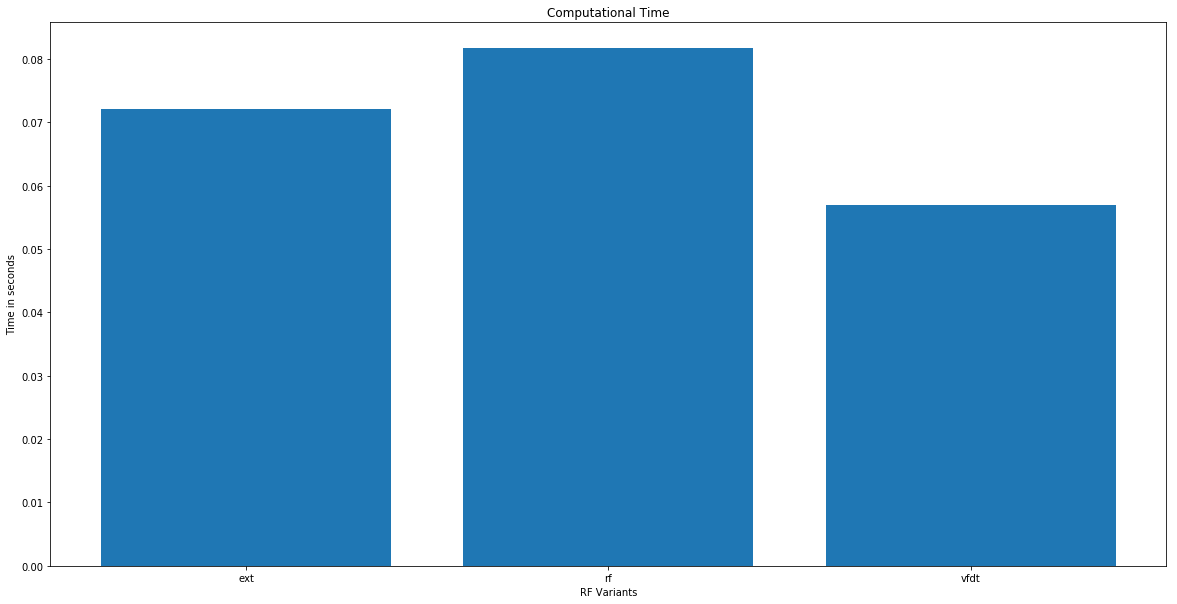

In [425]:
plt.figure(figsize=(20,10))
plt.title('Computational Time')
plt.ylabel('Time in seconds')
plt.xlabel('RF Variants')
plt.bar(times_small.keys(), times_small.values())

<Container object of 3 artists>

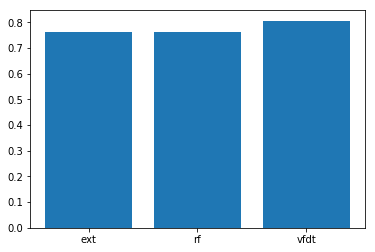

In [420]:
plt.bar(scores_small.keys(), scores_small.values())

In [377]:
from sklearn.datasets import make_blobs, make_classification

In [433]:
X, y = make_classification(n_samples=100000, n_features=10, n_redundant=2, n_informative=2, n_classes=2, n_clusters_per_class=2, shuffle=False)

In [387]:
import numpy as np

In [380]:
pd.DataFrame(np.column_stack([X,y])).to_csv('test.csv')

In [394]:
times_large = {}
scores_large = {}

In [434]:
s = time()
rf = RandomForestClassifier(random_state=777,min_samples_split=10)
scores = cross_val_score(rf, X, y)
e = time()
times_large.update({'rf':(e-s)})
scores_large.update({'rf':scores.mean()})

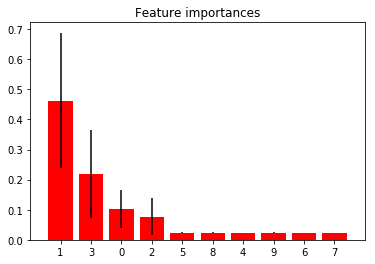

In [435]:
rf.fit(X, y)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [436]:
s = time()
et = ExtraTreesClassifier(random_state=777,min_samples_split=10)
scores = cross_val_score(et, X, y)
e = time()
times_large.update({'ext':(e-s)})
scores_large.update({'ext':scores.mean()})

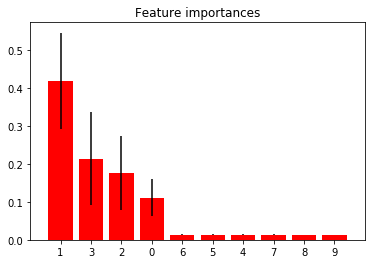

In [437]:
et.fit(X, y)
importances = et.feature_importances_
std = np.std([tree.feature_importances_ for tree in et.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

<Container object of 2 artists>

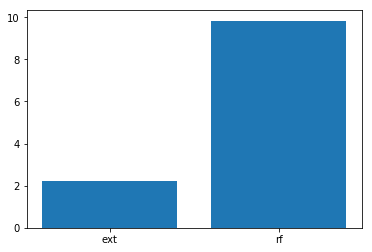

In [384]:
plt.bar(times_large.keys(), times_large.values())

<Container object of 2 artists>

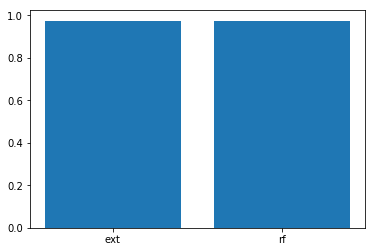

In [385]:
plt.bar(scores_large.keys(), scores_large.values())

In [159]:
s = time()
onrf = ExtraTreesClassifier(n_estimators=1, random_state=777,min_samples_split=10, warm_start=True)
indices = np.array([[i, i+100] for i in range(0,len(X)-101,100)])
count = 0
for i in indices:
    current_acc = 0
    count += 1 
    X_batch = X[i[0]:i[1]]
    y_batch = y[i[0]:i[1]]
    if count == 1:
        onrf.fit(X_batch, y_batch)
    else:
        count += 1
        onrf.n_estimators += 1
        onrf.fit(X_batch, y_batch)

e = time()
print(e-s)

1.403228998184204


In [180]:
import sys
sys.path.insert(0,'/Users/jannes/GU Modules/Statistical Learning for Big Data/code/Mini 6/StreamingXTREE/src')

In [409]:
import numpy as np
import pandas as pd
import math


# VFDT node class
class vfdt_node:
    # parameter nijk: statistics of feature i, value j, class k
    def __init__(self, possible_split_features):
        self.parent = None
        self.children = None
        self.split_feature = None
        self.new_examples_seen = 0
        self.total_examples_seen = 0
        self.class_frequency = {}
        self.nijk = {i:{} for i in possible_split_features}
        self.possible_split_features = possible_split_features

    def add_children(self, split_feature, children):
        if (not children):
            raise Exception('Parameter children is empty')
        self.split_feature = split_feature
        self.children = children
        self.nijk.clear()  # reset stats

    # recursively trace down the tree to distribute data examples to corresponding leaves
    def sort_example(self, example):
        value = 0
        if (self.children != None):
            index = self.possible_split_features.index(self.split_feature)
            value = example[:-1][index]
            return(self.children[value].sort_example(example))
        else:
            return(self)

    def is_leaf(self):
        return(self.children == None)

    # for debugging purpose, not a essential function
    def display_children(self):
        if (self.is_leaf()):
            print('It is leaf')
        else:
            print(list(self.children.keys()))
            for key in self.children:
                print(self.children[key].split_feature, end=' ')
            print()

    # the most frequent classification
    def most_frequent(self):
        if (self.class_frequency):
            prediction = max(self.class_frequency, key=self.class_frequency.get)
        else:
            # if self.class_frequency dict is empty, go back to parent
            class_frequency = self.parent.class_frequency
            prediction = max(class_frequency, key=class_frequency.get)
        return(prediction)

    # upadate leaf stats in order to calculate infomation gain
    def update_stats(self, example):
        label = example[-1]
        feats = self.possible_split_features
        for i in feats:
            if (i != None):
                value = example[:-1][feats.index(i)]
                if (value not in self.nijk[i]):

                    d = {label : 1}
                    self.nijk[i][value] = d
                else:
                    if (label not in self.nijk[i][value]):
                        self.nijk[i][value][label] = 1
                    else:
                        self.nijk[i][value][label] += 1
        self.total_examples_seen += 1
        self.new_examples_seen += 1
        if (label not in self.class_frequency):
            self.class_frequency[label] = 1
        else:
            self.class_frequency[label] += 1

    # use hoeffding tree model to test node split, return the split feature
    def splittable(self, delta, nmin):
        if(self.new_examples_seen < nmin):
            return(None)
        else:
            self.new_examples_seen = 0  # reset

        mx = 0
        second_mx = 0
        Xa = ''
        for feature in self.possible_split_features:
            if (feature != None):
                value = self.info_gain(feature)
                if (value > mx):
                    mx = value
                    Xa = feature
                elif (value < mx and value > second_mx):
                    second_mx = value
        R = math.log10(len(self.class_frequency))
        sigma = self.hoeffding_bound(R, delta, self.total_examples_seen)
        if (mx - second_mx > sigma):
            return(Xa)
        #elif (sigma < tau and mx - second_mx < tau):
            #return(Xa)
        else:
            return(None)

    def hoeffding_bound(self, R, delta, n):
        return(math.sqrt((R*R) * math.log(1/delta) / (2 * n)))

    def entropy(self, class_frequencies):
        total_examples = 0
        for k in class_frequencies:
            total_examples += class_frequencies[k]
        if (total_examples == 0):
            return(0)

        entropy = 0
        for k in class_frequencies:
            if(class_frequencies[k] != 0):
                entropy += -(class_frequencies[k] / float(total_examples)) * math.log2(class_frequencies[k] / float(total_examples))
            else:
                entropy += 0

        return(entropy)

    # nijk: attribute i, value j of class k
    def info_gain(self, featureID):
        njk = self.nijk[featureID]
        class_frequency = self.class_frequency

        total_examples = self.total_examples_seen
        if (total_examples == 0):
            return(0)
        entropy_before = self.entropy(class_frequency)

        # for each value j, class frequency must be counted
        entropy_after = 0
        for j in njk:
            count = 0
            for k in njk[j]:
                count += njk[j][k]
            entropy_after += (count/float(total_examples)) * (self.entropy(njk[j]))

        ig = entropy_before - entropy_after
        return ig

    def get_visualization(self, indent):
        if (self.is_leaf()):
            return(indent + ' Leaf\n')
        else:
            visualization = ''
            for key in self.children:
                visualization += indent + self.split_feature + ' = ' + str(key) + ':\n'
                visualization += self.children[key].get_visualization(indent + ' | ')
            return(visualization)

# very fast decision tree class, i.e. hoeffding tree
class vfdt:
    # parameters
    # feature_values  # number of values of each feature # dict
    # feature_values = {feature:[unique values list]}
    # delta   # used for hoeffding bound
    # tau  # used to deal with ties
    # nmin  # used to limit the G computations

    def __init__(self, feature_values, delta, nmin):
        self.feature_values = feature_values
        self.delta = delta
        #self.tau = tau
        self.nmin = nmin
        features = list(feature_values.keys())
        self.root = vfdt_node(features)
        self.n_examples_processed = 0

    # update the tree by adding training example
    def update(self, example):
        self.n_examples_processed += 1
        node = self.root.sort_example(example)
        node.update_stats(example)

        split_feature = node.splittable(self.delta, self.nmin)
        if (split_feature != None):
            children =  self.node_split(node, split_feature)
            node.add_children(split_feature, children)
            for key in children:
                children[key].parent = node

    # split node, produce children
    def node_split(self, node, split_feature):
        features = node.possible_split_features
        # replace deleted split feature with None
        new_features = [None if f == split_feature else f for f in features]
        children = {}
        for v in self.feature_values[split_feature]:
            children[v] = vfdt_node(new_features)
        return(children)

    # predict test example's classification
    def predict(self, example):
        leaf = self.root.sort_example(example)
        prediction = leaf.most_frequent()
        return(prediction)

    # accuracy of a test set
    def accuracy(self, examples):
        correct = 0
        for ex in examples:
            if (self.predict(ex) == ex[-1]):
                correct +=1
        return(float(correct) / len(examples))


def test_run():
    start_time = time()

    # bank.csv whole data size: 4521
    # if more than 4521, it revert back to 4521
    rows = 100000
    # n_training = int(0.8 * rows)
    # read_csv has parameter nrows=n that read the first n rows
    df = pd.read_csv('test.csv', nrows=rows, header=0, sep=",")
    title = list(df.columns.values)
    features = title[:-1]
    # need to pre-process data before training, discretize continous data
    # unique values for each feature to use in VFDT
    feature_values = {f:None for f in features}
    bins = 10
    for f in features:
        if (df[f].dtype != np.float64 and df[f].dtype != np.int64):
            feature_values[f] = df[f].unique()
            temp = len(feature_values[f])
            if (temp > bins):
                bins = temp

    # bins for discretization
    # set bins to maximum unique values of discrete features
    # could use different method, then set labels equals to bins
    labels = [i for i in range(1, bins+1)]  # labels to replace bins

    for f in features:
        if (df[f].dtype == np.float64 or df[f].dtype == np.int64):
            # check if feature value is continous
            # pd.cut to discretize continous feature values in same size bins.
            # pd.qcut put same number of data in each bin
            # But it doesn't work here because not enough values in each bin.
            df[f] = pd.cut(df[f], bins, labels=labels)
            feature_values[f] = df[f].unique()

    # convert df to data examples
    train_len = 100000
    array = df.head(train_len).values
    set1 = []
    set2 = []
    set3 = []
    possible_split_features = title[:-1]
    count = 0
    for i in range(len(array)):
        count += 1
        if (count <= train_len//4):
            set1.append(array[i])
        elif (count > train_len//4 and count <= train_len//2):
            set2.append(array[i])
        else:
            set3.append(array[i])
    # to simulate continous training, modify the tree for each training set
    examples = [set1, set2, set3]

    # test set is different from training set
    n_test = 100000
    test_set = df.tail(n_test).values
    test = []
    for i in range(len(test_set)):
        test.append(test_set[i])

    # heoffding bound parameter delta: with 1 - delta probability
    # the true mean is at least r - gamma
    # vfdt parameter nmin: test split if new sample size > nmin
    delta = 0.05
    nmin = 10
    tree = vfdt(feature_values, delta, nmin)
    print('Total data size: ', rows)
    print('Test set (tail): ', len(test_set))
    n = 0
    results = []
    for training_set in examples:
        n += len(training_set)
        for ex in training_set:
            tree.update(ex)
        print('Training set:', n, end=', ')
        a = tree.accuracy(test)
        print('ACCURACY: %.4f' % a)
        results.append(a)
        
    scores_large.update({'vfdt': np.array(results)[-1]})

    #print(tree.root.get_visualization('$'))

    print("--- Running time: %.6f seconds ---" % (time() - start_time))
    times_large.update({'vfdt': time() - start_time})

In [410]:
test_run()

Total data size:  100000
Test set (tail):  100000
Training set: 25000, ACCURACY: 0.9617
Training set: 50000, ACCURACY: 0.9647
Training set: 100000, ACCURACY: 0.9671
--- Running time: 6.265743 seconds ---


In [411]:
scores_large

{'ext': 0.9118699973294425, 'rf': 0.9084900109270105, 'vfdt': 0.96707}

In [412]:
times_large

{'ext': 1.8877499103546143, 'rf': 9.893658876419067, 'vfdt': 6.265780925750732}

<Container object of 3 artists>

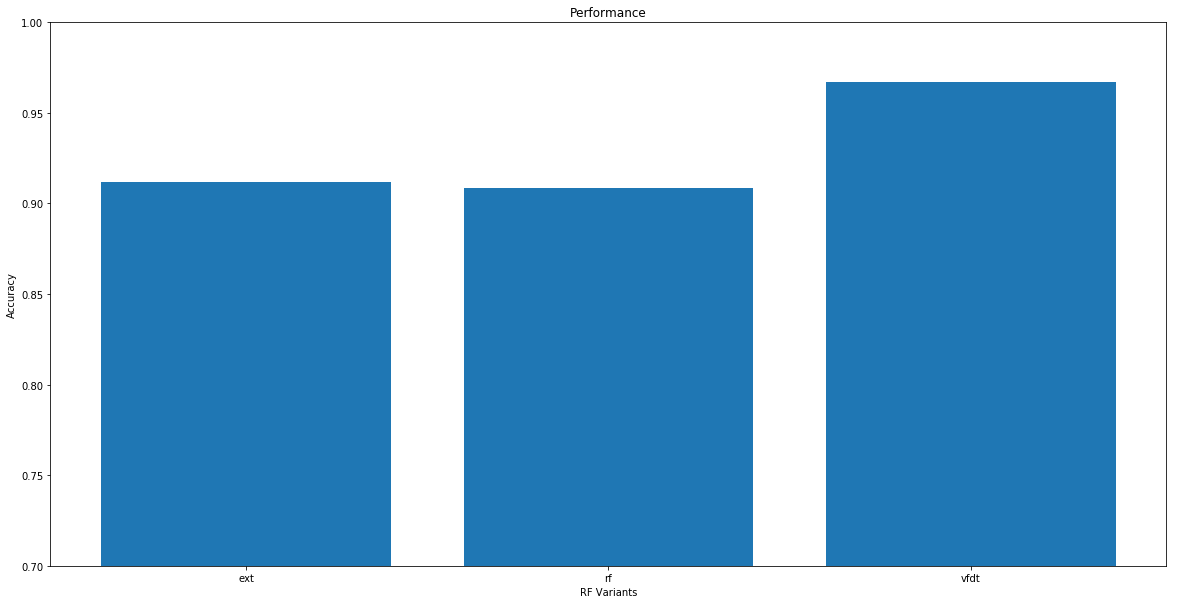

In [431]:
plt.figure(figsize=(20,10))
plt.title('Performance')
plt.ylabel('Accuracy')
plt.xlabel('RF Variants')
plt.ylim(0.7,1)
plt.bar(scores_large.keys(), scores_large.values())